# <font size=5> **BANA212 Final Project**

<font color=Gray size=4> By Group 3

<font size=4>  Xueting Li, Sammi Chang, Jialu Li, Junguo He

## <font color=seagreen size=6> **How to Produce Popular Music**

<font size=4> Why a new-released song became a hot cake? What features contribute a popular song? We are very curious about whether there are common features among popular songs, such as the loudness, tempo, key. If we testify there indeed some common features contribute the popularity of the songs, it may inspire the music producers to adjust some parameters of their music products. Or it may help operation managers of music company to improve their algorithm to recommend music to their users. 

<font size=4> Spotify provides us a very good resourses to realize our idea.  

<img src="https://images.indianexpress.com/2020/05/spotify-bloom-759.jpg">

## <font color=seagreen size=4.5> Importing the Neccessary Modules

In [10]:
import re
import requests
import base64
import datetime
from bs4 import BeautifulSoup
import urllib
import re
import pandas as pd
import numpy as np
from urllib.parse import urlencode
from collections import Counter
import warnings
warnings.filterwarnings("ignore")

import seaborn as sns
sns.set_style("white")
import matplotlib.pyplot as plt

import sklearn
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score,f1_score,precision_score, recall_score
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.preprocessing import LabelEncoder
from sklearn import tree
from sklearn.metrics import classification_report

## <font color=seagreen size=4.5> Retrieving data using Spotify API

<font size=3.5> Spotify is one of the world’s leading music streaming platforms and offers an official API we can use to access public data from. Spotify’s API allows anyone with a Spotify account to scrape data on newly released albums, returning back standard data like the artists, track information, duration - and even a link to download a 30-second sample of each track. What’s even more interesting, is that Spotify also can send back “audio features” about each track, offering insight into how its recoomendation algorithm works.

<font size=3.5> To get the authorization for Spotify API, we need to log in with a Spotify account and the password, which are client id and client secret respectively. Then we need to get token to get authorized to scrap data from Spotify.

In [255]:
# Before we get the token, we need to register a client account and set an application.
# Then we got the client id and client secret for the next step.
client_id='59478b79b5ab495793b253f2f8d1291f'
client_secret='f2bbd4d750de48b5a72f037ec02f4642'

### <font color=darkslategray size=3.5> Get the Access Token for Authorization

In [477]:
class SpotifyAPI(object):
    access_token=None
    acess_token_expires=datetime.datetime.now()
    access_token_did_expire=True
    client_id=None
    client_secret=None
    token_url='https://accounts.spotify.com/api/token'
    
    def __init__(self,client_id,client_secret,*args,**kwargs):
        super().__init__(*args,**kwargs)
        self.client_id=client_id
        self.client_secret=client_secret
    
    def get_client_credentials(self):
        '''
        Returns a base64 encoded string
        '''
        client_id=self.client_id
        client_secret=self.client_secret
        if client_secret==None or client_id==None:
            raise Exception('You must set client_id and client_secret')
        client_creds= f"{client_id}:{client_secret}"
        client_creds_b64=base64.b64encode(client_creds.encode())
        return client_creds_b64.decode()
    
    def get_token_headers (self):
        client_creds_b64=self.get_client_credentials()
        return {
            'Authorization':f"Basic {client_creds_b64}"
        }
    
    def get_token_data(self):
        return {
            "grant_type":"client_credentials"
        }
    
    def perform_auth(self):
        token_url=self.token_url
        token_data=self.get_token_data()
        token_headers=self.get_token_headers()
        r =requests.post(token_url,data=token_data,headers=token_headers)
        if r.status_code not in range(200,299):
            return False
        data=r.json()
        now=datetime.datetime.now()
        access_token=data['access_token']
        expires_in=data['expires_in'] # seconds
        expires=now+datetime.timedelta(seconds=expires_in)
        self.access_token=access_token
        self.access_token_expires=expires
        self.access_token_did_expire=expires<now
        return True

In [903]:
spotify=SpotifyAPI(client_id,client_secret)
print(spotify.perform_auth())

# Get the Token
access_token=spotify.access_token
print('''
My Token is: 
{}'''.format(access_token))

True

My Token is: 
BQA5x9WtBT52kByPeHRYcMTvTmcAI1Sqi3kkfoAEXbum06Z49d9w85fRAUKw6C_U6viU4Cig2r7hWWXK1E0


### <font color=darkslategray size=3.5> Get Albums Released in Year of 2020

<font size=3.5> **Get Album Lists using Billboard Albums**: To search for the albums released in each year, we first collected data from Billboard year-end album chart. See: https://www.billboard.com/charts/year-end/2020/top-billboard-200-albums

In [468]:
search=pd.DataFrame()
for n in range(2005,2021):
    link = "https://www.billboard.com/charts/year-end/{}/top-billboard-200-albums".format(n)
    response = requests.get(link)
    page= response.text
    soup = BeautifulSoup(page, 'lxml')
    #print(soup.prettify())

    all_matches = soup.find_all('div', attrs={'class':['ye-chart-item__primary-row']})
    for i in all_matches:
        rank=i.find('div',class_="ye-chart-item__rank")
        text=i.find('div',class_="ye-chart-item__text")
        album_name=text.find('div',class_="ye-chart-item__title")
        artist=text.find('div',class_="ye-chart-item__artist")
        album_name=album_name.text
        album_name=album_name.replace("\n", "")
        album_name=album_name.replace(" (EP)", "")
        artist=artist.text.replace("\n", "")
        #print(album_name)
        #print(artist)
        #print(rank.text)
        new=pd.DataFrame({'rank':rank.text.replace("\n", ""),'album':album_name,
                          'artist':artist,'year':n},index=[0])
        search=search.append(new,ignore_index=True)

In [490]:
search.head(10)

,rank,album,artist,year
0,1,The Massacre,50 Cent,2005
1,2,Encore,Eminem,2005
2,3,American Idiot,Green Day,2005
3,4,The Emancipation Of Mimi,Mariah Carey,2005
4,5,Breakaway,Kelly Clarkson,2005
5,6,Love. Angel. Music. Baby.,Gwen Stefani,2005
6,7,Destiny Fulfilled,Destiny's Child,2005
7,8,How To Dismantle An Atomic Bomb,U2,2005
8,9,Greatest Hits,Shania Twain,2005
9,10,Feels Like Today,Rascal Flatts,2005


In [483]:
album=pd.DataFrame()
for i in range(0,len(search)):
        headers={
            'Authorization':f"Bearer {access_token}"
        }
        endpoint='https://api.spotify.com/v1/search'
        data=urlencode({'q':'album:{} artist:{} year:{}'.format(search['album'][i],
                                                                search['artist'][i],search['year'][i]),
                        'type':'album','market':'US'})
        lookup_url=f'{endpoint}?{data}'
        r=requests.get(lookup_url,headers=headers)
        result=r.json()
        #print(result)
        if result['albums']['items']!=[]:
            for j in result['albums']['items']:
                #print(j['id'])
                new=pd.DataFrame({'album_id':j['id'],'album_name':j['name'],
                                  'release_date':j['release_date'],'artist':j['artists'][0]['name'],
                                  'artist_id':j['artists'][0]['id'],'query_year':search['year'][i]},index=[0])
                new['release_date']=pd.to_datetime(new['release_date'],format='%Y-%m-%d')               
     # To filter out the albums derived from the original ones, 
     # we built two columns of 'year' and 'query_year,
     # which represent the month the album released and the month the original album released respectively
                new['year']=new['release_date'].dt.year
                album=album.append(new,ignore_index=True)
album=album.loc[album['year']==album['query_year']]

In [484]:
album

,album_id,album_name,release_date,artist,artist_id,query_year,year
0,2pidzXTaHV4WaIJYRxKDCH,The Massacre,2005-03-03,50 Cent,3q7HBObVc0L8jNeTe5Gofh,2005,2005
1,2eVeRZTU84r5D7m3uIczxe,The Massacre,2005-03-03,50 Cent,3q7HBObVc0L8jNeTe5Gofh,2005,2005
2,43iBTEWECK7hSnE0p6GgNo,The Emancipation of Mimi,2005-01-01,Mariah Carey,4iHNK0tOyZPYnBU7nGAgpQ,2005,2005
3,0yv6r2Prvx8j0tibLJf9pj,The Emancipation of Mimi,2005-01-01,Mariah Carey,4iHNK0tOyZPYnBU7nGAgpQ,2005,2005
4,4E7bV0pzG0LciBSWTszra6,X&Y,2005-06-07,Coldplay,4gzpq5DPGxSnKTe4SA8HAU,2005,2005
...,...,...,...,...,...,...,...
2429,2x2cG56QicVfymWnRF0Nmj,Ordinary Man,2020-02-21,Ozzy Osbourne,6ZLTlhejhndI4Rh53vYhrY,2020,2020
2430,39yp6JEfOhqVEpCiy6i6M3,Ordinary Man (feat. Elton John),2020-01-10,Ozzy Osbourne,6ZLTlhejhndI4Rh53vYhrY,2020,2020
2431,35c0JHNJdjCAFbhEQ4lzS4,Ordinary Man,2020-07-10,Ozzy Osbourne,6ZLTlhejhndI4Rh53vYhrY,2020,2020
2432,5YOvg682zFOleCiSndLnZr,NCT #127 Neo Zone - The 2nd Album,2020-03-06,NCT 127,7f4ignuCJhLXfZ9giKT7rH,2020,2020


In [485]:
album=album.drop_duplicates(['album_name','artist'])
album

,album_id,album_name,release_date,artist,artist_id,query_year,year
0,2pidzXTaHV4WaIJYRxKDCH,The Massacre,2005-03-03,50 Cent,3q7HBObVc0L8jNeTe5Gofh,2005,2005
2,43iBTEWECK7hSnE0p6GgNo,The Emancipation of Mimi,2005-01-01,Mariah Carey,4iHNK0tOyZPYnBU7nGAgpQ,2005,2005
4,4E7bV0pzG0LciBSWTszra6,X&Y,2005-06-07,Coldplay,4gzpq5DPGxSnKTe4SA8HAU,2005,2005
5,4PrPbmm0gKvaD3rerOXFg8,The Documentary,2005-01-01,The Game,0NbfKEOTQCcwd6o7wSDOHI,2005,2005
6,6gQ2EJveKATDWJKQaW7IsR,DVD Bonus Audio (from Goodies. The Videos and ...,2005-07-12,Ciara,2NdeV5rLm47xAvogXrYhJX,2005,2005
...,...,...,...,...,...,...,...
2427,54B6i7KlSGD9fAzKQB7n89,T R A P S O U L (Deluxe),2020-09-25,Bryson Tiller,2EMAnMvWE2eb56ToJVfCWs,2020,2020
2429,2x2cG56QicVfymWnRF0Nmj,Ordinary Man,2020-02-21,Ozzy Osbourne,6ZLTlhejhndI4Rh53vYhrY,2020,2020
2430,39yp6JEfOhqVEpCiy6i6M3,Ordinary Man (feat. Elton John),2020-01-10,Ozzy Osbourne,6ZLTlhejhndI4Rh53vYhrY,2020,2020
2432,5YOvg682zFOleCiSndLnZr,NCT #127 Neo Zone - The 2nd Album,2020-03-06,NCT 127,7f4ignuCJhLXfZ9giKT7rH,2020,2020


<font size=3.5> **Search tracks of the albums via Spotify API**: After we got album information, we attempted to scrap the musics in each albums and then put them into one table.

In [428]:
tracks=pd.DataFrame()
album_list=list(album['album_id'])
headers={
    'Authorization':f"Bearer {access_token}"
}
for i in range(0,len(album_list)):
    track_id=album_list[i]
    url_track='https://api.spotify.com/v1/albums/{}/tracks?market=US'.format(track_id)
    #print(url_track)
    r_track=requests.get(url_track,headers=headers)
    result_track=r_track.json()
    #print(result_track)
    for j in result_track['items']:
        #print(j)
        new_track=pd.DataFrame({'album_id':album_list[i],'track_id':j['id'],'track_name':j['name'],
                                'disc_number':j['disc_number'],'duration_ms':j['duration_ms'],
                                'explicit':j['explicit']},index=[0])
        tracks=tracks.append(new_track,ignore_index=True)
tracks.head()

,album_id,track_id,track_name,disc_number,duration_ms,explicit
0,47BiFcV59TQi2s9SkBo2pb,3Tj1luJyKPQt7WbrqpJ2Az,Cold Wind Blows,1,303733,True
1,47BiFcV59TQi2s9SkBo2pb,66h8hB4In6t725WtAPL23J,Talkin’ 2 Myself,1,300426,True
2,47BiFcV59TQi2s9SkBo2pb,6HLZaECJKDjNE0jiGBeqxz,On Fire,1,213493,True
3,47BiFcV59TQi2s9SkBo2pb,7kNlRLC9PEH8nXMVawssMx,Won't Back Down,1,265906,True
4,47BiFcV59TQi2s9SkBo2pb,1ne7JVHEPnoncXzQunQVKW,W.T.P.,1,238173,True


In [429]:
tracks.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16391 entries, 0 to 16390
Data columns (total 6 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   album_id     16391 non-null  object
 1   track_id     16391 non-null  object
 2   track_name   16391 non-null  object
 3   disc_number  16391 non-null  int64 
 4   duration_ms  16391 non-null  int64 
 5   explicit     16391 non-null  bool  
dtypes: bool(1), int64(2), object(3)
memory usage: 656.4+ KB


<font size=3.5> **Search artists of the albums via Spotify API**

In [904]:
artists=pd.DataFrame()
artist_list=list(album['artist_id'])
headers={
    'Authorization':f"Bearer {access_token}"
}
for i in range(0,len(artist_list)):
    artist_id=artist_list[i]
    url='https://api.spotify.com/v1/artists/{}'.format(artist_id)
    #print(url)
    r=requests.get(url,headers=headers)
    result=r.json()
    #print(result)
    #for j in r1['tracks']:
        #print(j) 
    if result['genres']==[]:
        new_artist=pd.DataFrame({'artist_id':result['id'],'artist':result['name'],'followers':result['followers']['total'],'genres':None},index=[0])
        artists=artists.append(new_artist,ignore_index=True)
    else:
        new_artist=pd.DataFrame({'artist_id':result['id'],'artist':result['name'],'followers':result['followers']['total'],'genres':result['genres'][0]},index=[0])
        artists=artists.append(new_artist,ignore_index=True)
artists.head()

,artist_id,artist,followers,genres
0,3q7HBObVc0L8jNeTe5Gofh,50 Cent,6523317,east coast hip hop
1,3q7HBObVc0L8jNeTe5Gofh,50 Cent,6523317,east coast hip hop
2,4iHNK0tOyZPYnBU7nGAgpQ,Mariah Carey,6108508,dance pop
3,4iHNK0tOyZPYnBU7nGAgpQ,Mariah Carey,6108508,dance pop
4,4gzpq5DPGxSnKTe4SA8HAU,Coldplay,28036320,permanent wave


### <font color=darkslategray size=3.5> Get Features of Songs

<font size=3.5> Spotify officially provides audio features for songs, including the attributes below:

| Key | Value Type | Description |
| :------| :------: | :------ |
| id | str | The Spotify ID for the track. |
| duration_ms | int | The duration of the track in milliseconds. |
| key | int | The estimated overall key of the track. Integers map to pitches using standard Pitch Class notation . |
| mode | int | Mode indicates the modality (major or minor) of a track, the type of scale from which its melodic content is derived. Major is represented by 1 and minor is 0. |
| time_signature | int | An estimated overall time signature of a track. The time signature (meter) is a notational convention to specify how many beats are in each bar (or measure). |
| acousticness | float | A confidence measure from 0.0 to 1.0 of whether the track is acoustic. 1.0 represents high confidence the track is acoustic. |
| danceability | float | Danceability describes how suitable a track is for dancing based on a combination of musical elements including tempo, rhythm stability, beat strength, and overall regularity. A value of 0.0 is least danceable and 1.0 is most danceable.  |
| energy | float | Danceability describes how suitable a track is for dancing based on a combination of musical elements including tempo, rhythm stability, beat strength, and overall regularity. A value of 0.0 is least danceable and 1.0 is most danceable. | 
| instrumentalness | float | Predicts whether a track contains no vocals. “Ooh” and “aah” sounds are treated as instrumental in this context. Rap or spoken word tracks are clearly “vocal”. The closer the instrumentalness value is to 1.0, the greater likelihood the track contains no vocal content. Values above 0.5 are intended to represent instrumental tracks, but confidence is higher as the value approaches 1.0.  |
| liveness | float | Detects the presence of an audience in the recording. Higher liveness values represent an increased probability that the track was performed live. A value above 0.8 provides strong likelihood that the track is live.  |
| loudness | float | The overall loudness of a track in decibels (dB). Loudness values are averaged across the entire track and are useful for comparing relative loudness of tracks. Loudness is the quality of a sound that is the primary psychological correlate of physical strength (amplitude). Values typical range between -60 and 0 db.  |
| speechiness | float | Speechiness detects the presence of spoken words in a track. The more exclusively speech-like the recording (e.g. talk show, audio book, poetry), the closer to 1.0 the attribute value. Values above 0.66 describe tracks that are probably made entirely of spoken words. Values between 0.33 and 0.66 describe tracks that may contain both music and speech, either in sections or layered, including such cases as rap music.  |
| valence | float | A measure from 0.0 to 1.0 describing the musical positiveness conveyed by a track. Tracks with high valence sound more positive (e.g. happy, cheerful, euphoric), while tracks with low valence sound more negative (e.g. sad, depressed, angry).  |
| tempo | float | The overall estimated tempo of a track in beats per minute (BPM). In musical terminology, tempo is the speed or pace of a given piece and derives directly from the average beat duration.  |
| popularity | int | The popularity of the track. The value will be between 0 and 100, with 100 being the most popular. The popularity of a track is a value between 0 and 100, **with 100 being the most popular**. The popularity is calculated by algorithm and is based, in the most part, on the total number of plays the track has had and how recent those plays are. Generally speaking, songs that are being played a lot now will have a higher popularity than songs that were played a lot in the past. Duplicate tracks (e.g. the same track from a single and an album) are rated independently. Artist and album popularity is derived mathematically from track popularity. Note that the popularity value may lag actual popularity by a few days: the value is not updated in real time. |

<font size=3> **Get Basic Infomation of tracks**

In [286]:
basic=pd.DataFrame()
track_list=list(tracks['track_id'])
headers={
    'Authorization':f"Bearer {access_token}"
}
for i in range(0,len(track_list)):
    track_id=track_list[i]
    url_track='https://api.spotify.com/v1/tracks/{}'.format(track_id)
    #print(url_track)
    r=requests.get(url_track,headers=headers)
    r1=r.json()
    #print(r1['name'])
    #for j in r1['tracks']:
        #print(j) 
    new=pd.DataFrame({'name':r1['name'],'popularity':r1['popularity'],'track_id':r1['id'],
                         'album':r1['album']['name'],'release_date':r1['album']['release_date']},index=[0])
    basic=basic.append(new,ignore_index=True)
basic.head()

,name,popularity,track_id,album,release_date
0,Dead and Gone,27,4Y3iDGeGwExfiJtyMvqeNk,Dead and Gone,2020-01-03
1,Cold,21,3PJ3uvDOZHwQAj05boanVd,Dead and Gone,2020-01-03
2,Crawl,19,5TmA4Rm6UMckuqMTzGW36I,Dead and Gone,2020-01-03
3,Dead and Gone - StoneburnerRemix,12,04cK5OjY9oPDebva2hUZQ7,Dead and Gone,2020-01-03
4,"Cold - StabWalts 12"" Dance Mix",11,483DHa7JWgY347cwdNANBi,Dead and Gone,2020-01-03


In [287]:
basic.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2893 entries, 0 to 2892
Data columns (total 5 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   name          2893 non-null   object
 1   popularity    2893 non-null   int64 
 2   track_id      2893 non-null   object
 3   album         2893 non-null   object
 4   release_date  2893 non-null   object
dtypes: int64(1), object(4)
memory usage: 113.1+ KB


<font size=3> **Get autio features of tracks**

In [293]:
features=pd.DataFrame()
track_list=list(tracks['track_id'])
headers={
    'Authorization':f"Bearer {access_token}"
}
for i in range(0,len(track_list)):
    track_id=track_list[i]
    url_track='https://api.spotify.com/v1/audio-features/{}'.format(track_id)
    #print(url_track)
    r=requests.get(url_track,headers=headers)
    r2=r.json()
    #print(r2['id'])
    #for j in r1['tracks']:
        #print(j) 
    new=pd.DataFrame({'track_id':r2['id'],'danceability':r2['danceability'],'energy':r2['energy'],
                      'key':r2['key'],'loudness':r2['loudness'],'mode':r2['mode'],
                     'speechiness':r2['speechiness'],'acousticness':r2['acousticness'],
                     'instrumentalness':r2['instrumentalness'],'liveness':r2['liveness'],
                      'valence':r2['valence'],'tempo':r2['tempo']},index=[0])
    features=features.append(new,ignore_index=True)
features.head()

,track_id,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo
0,4Y3iDGeGwExfiJtyMvqeNk,0.535,0.803,7,-7.589,1,0.0370,0.000056,0.000163,0.0672,0.526,120.020
1,3PJ3uvDOZHwQAj05boanVd,0.530,0.897,9,-4.990,0,0.0361,0.000119,0.016800,0.1040,0.298,124.003
2,5TmA4Rm6UMckuqMTzGW36I,0.380,0.771,9,-7.333,1,0.0713,0.009040,0.000000,0.3580,0.231,163.902
3,04cK5OjY9oPDebva2hUZQ7,0.517,0.841,2,-6.626,1,0.0451,0.003970,0.000004,0.0922,0.336,125.020
4,483DHa7JWgY347cwdNANBi,0.599,0.616,2,-8.254,1,0.0379,0.000231,0.586000,0.0820,0.328,129.984


### <font color=darkslategray size=3.5>Merge the Data Together

In [519]:
audio=pd.merge(basic,features,how='inner',on='track_id')
data=pd.merge(audio,tracks,how='inner',on='track_id')
data=pd.merge(data,album,how='inner',on='album_id')
data=pd.merge(data,artists,how='inner',on='artist_id')
data=data.rename(columns={'release_date_y':'release_date','artist_x':'artist'})
data=data[['name','track_id', 'release_date',
       'album_id', 'track_name', 'album','artist', 'artist_id','followers','genres', 
           'disc_number', 'duration_ms', 'explicit','popularity', 
       'danceability', 'energy', 'key', 'loudness', 'mode', 'speechiness',
       'acousticness', 'instrumentalness', 'liveness', 'valence', 'tempo']]
data.head()
audio.head()
data.to_csv('data_spotify.csv')

,name,popularity,track_id,album,release_date,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo
0,Dead and Gone,27,4Y3iDGeGwExfiJtyMvqeNk,Dead and Gone,2020-01-03,0.535,0.803,7,-7.589,1,0.0370,0.000056,0.000163,0.0672,0.526,120.020
1,Cold,21,3PJ3uvDOZHwQAj05boanVd,Dead and Gone,2020-01-03,0.530,0.897,9,-4.990,0,0.0361,0.000119,0.016800,0.1040,0.298,124.003
2,Crawl,19,5TmA4Rm6UMckuqMTzGW36I,Dead and Gone,2020-01-03,0.380,0.771,9,-7.333,1,0.0713,0.009040,0.000000,0.3580,0.231,163.902
3,Dead and Gone - StoneburnerRemix,12,04cK5OjY9oPDebva2hUZQ7,Dead and Gone,2020-01-03,0.517,0.841,2,-6.626,1,0.0451,0.003970,0.000004,0.0922,0.336,125.020
4,"Cold - StabWalts 12"" Dance Mix",11,483DHa7JWgY347cwdNANBi,Dead and Gone,2020-01-03,0.599,0.616,2,-8.254,1,0.0379,0.000231,0.586000,0.0820,0.328,129.984


## <font color=seagreen size=4.5> Data Visualization

<font size=4> After we merge all the data together, we tried to analyze the basic trends via data visualizaton.

### <font  color=darkslategray size=3.5> The Overall Data Distribution

In [23]:
data=pd.read_csv('/Users/lixueting/Desktop/MSBA/BANA 212/project/data_spotify.csv')
data['release_date']=pd.to_datetime(data['release_date'],format='%Y-%m-%d') 
data['year']=data['release_date'].dt.year
data=data.drop(columns='Unnamed: 0')
#data['duration_ms'].apply(lambda x: )

In [24]:
audio=data[['year','popularity', 'duration_ms', 'explicit', 'danceability', 'energy',
       'key', 'loudness', 'mode', 'speechiness', 'acousticness',
       'instrumentalness', 'liveness', 'valence', 'tempo','followers']]

audio.replace({'explicit': {False: 0, True: 1}}, inplace =True)
audio.head()

,year,popularity,duration_ms,explicit,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,followers
0,2005,39,41333,1,0.544,0.415,1,-14.188,1,0.161,0.06330,0.000327,0.3500,0.377,66.211,6519870
1,2005,55,231120,1,0.812,0.727,1,-5.156,1,0.277,0.17700,0.000000,0.2820,0.475,89.962,6519870
2,2005,46,184213,1,0.820,0.834,2,-5.243,1,0.124,0.18300,0.000818,0.1110,0.403,91.269,6519870
3,2005,55,231026,1,0.675,0.720,7,-3.929,1,0.310,0.00307,0.000259,0.0852,0.323,78.901,6519870
4,2005,51,255173,1,0.480,0.845,10,-4.127,0,0.303,0.01200,0.000000,0.3310,0.872,79.374,6519870


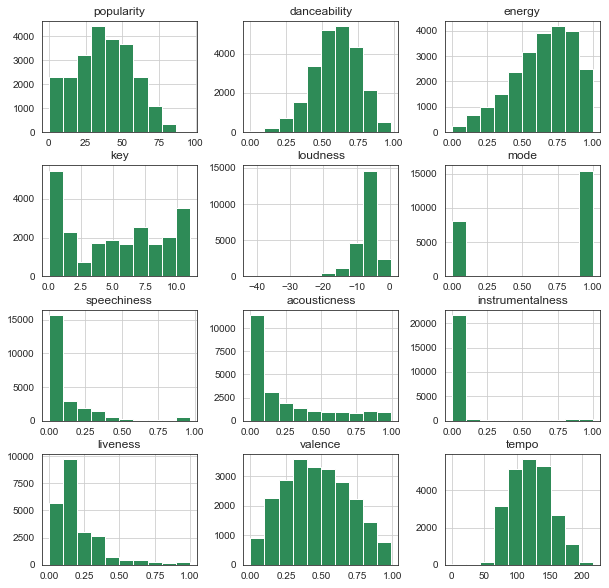

In [25]:
audio[['popularity', 'danceability', 'energy',
       'key', 'loudness', 'mode', 'speechiness', 'acousticness',
       'instrumentalness', 'liveness', 'valence', 'tempo']].hist(figsize = (10,10),color='seagreen')
plt.show()

### <font color=darkslategray size=3.5> Data Distribution by Year

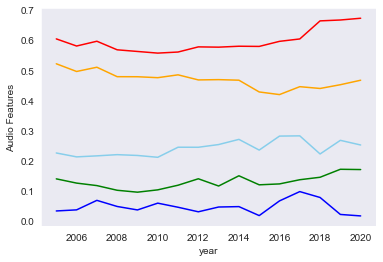

In [74]:
audio_year=audio.groupby('year').mean()

plt.plot(audio_year.speechiness, color='green', label='speechiness')
plt.plot(audio_year.danceability, color='red', label='danceability')
plt.plot(audio_year.acousticness,  color='skyblue', label='acousticness')
plt.plot(audio_year.instrumentalness, color='blue', label='instrumentalness')
plt.plot(audio_year.valence, color='orange', label='valence')

plt.ylabel('Audio Features')
plt.xlabel('year')
plt.show()

### <font color=darkslategray size=3.5> Word Cloud of Genre

In [27]:
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator
import os
import random

In [28]:
STOPWORDS.add("featuring")
STOPWORDS.add("songwriter")
STOPWORDS.add("nan")
STOPWORDS.add("the")
stopwords = set(STOPWORDS)

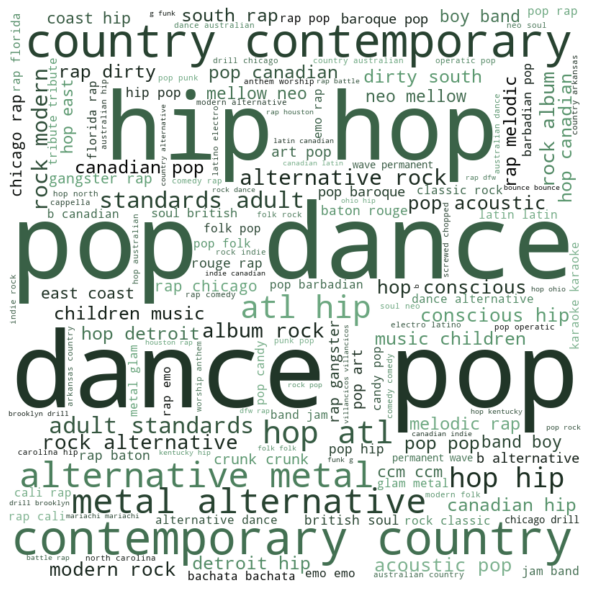

In [29]:
def green_color_func(word, font_size, position, orientation, random_state=None,
                    **kwargs):
    return "hsl(140, 25%%, %d%%)" % random.randint(1, 60)
_words = '' 
  
# iterate through the csv file 
for val in data.genres: 
      
    # typecaste each val to string 
    val = str(val)
  
    # split the value 
    tokens = val.split()
      
    _words += " ".join(tokens)+" "
  
wordcloud = WordCloud(width = 800, height = 800,
                background_color ='white',
                min_font_size = 10,random_state=1).generate(_words)

# plot the WordCloud image
plt.figure(figsize = (8, 8))
plt.imshow(wordcloud.recolor(color_func=green_color_func, random_state=3),
           interpolation="bilinear")
plt.axis("off")
plt.tight_layout(pad = 0)
plt.show()

## <font color=seagreen size=4.5> Classification Model

### <font  color=darkslategray size=4> Dealing with the data

In [30]:
# We export the tables into csv document, avoiding running the data collecting code again
data=pd.read_csv('/Users/lixueting/Desktop/MSBA/BANA 212/project/data_spotify.csv')
data['release_date']=pd.to_datetime(data['release_date'],format='%Y-%m-%d') 
data['year']=data['release_date'].dt.year
data=data.drop(columns='Unnamed: 0')

audio=data[['year','popularity', 'duration_ms', 'explicit', 'danceability', 'energy',
       'key', 'loudness', 'mode', 'speechiness', 'acousticness',
       'instrumentalness', 'liveness', 'valence', 'tempo','followers']]

audio.replace({'explicit': {False: 0, True: 1}}, inplace =True)
description=audio.describe()
description.to_excel('description.xlsx')

In [31]:
sc_X = StandardScaler()
scaled_audio =  pd.DataFrame(sc_X.fit_transform(audio.drop(["popularity",'year'],axis = 1),),
        columns=['duration_ms', 'explicit', 'danceability', 'energy',
       'key', 'loudness', 'mode', 'speechiness', 'acousticness',
       'instrumentalness', 'liveness', 'valence', 'tempo','followers'])
scaled_audio['year']=audio['year']
scaled_audio['popularity']=audio['popularity']
scaled_audio.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 23487 entries, 0 to 23486
Data columns (total 16 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   duration_ms       23487 non-null  float64
 1   explicit          23487 non-null  float64
 2   danceability      23487 non-null  float64
 3   energy            23487 non-null  float64
 4   key               23487 non-null  float64
 5   loudness          23487 non-null  float64
 6   mode              23487 non-null  float64
 7   speechiness       23487 non-null  float64
 8   acousticness      23487 non-null  float64
 9   instrumentalness  23487 non-null  float64
 10  liveness          23487 non-null  float64
 11  valence           23487 non-null  float64
 12  tempo             23487 non-null  float64
 13  followers         23487 non-null  float64
 14  year              23487 non-null  int64  
 15  popularity        23487 non-null  int64  
dtypes: float64(14), int64(2)
memory usage: 2

### <font  color=darkslategray size=4> Basic Data EDA

<font size=4> In the first step, we made a simple correlation matrix for all the attributes we are going to put into our models.

 <font size=3.5> **Correlation Heatgram**

<font size=4> The heat graph takes a closer look at the audio profile of the Spotify songs, and focuses on the connection between song features. The graph shows which properties of songs are more correlated with each by colors. 

According to the scale on the right, as the correlation box become more reddish it shows that two properties are more correlated with each other. We can see high correlation between energy & mode, energy & loudness, dancability & valence... The years column is particularly interesting, we can see that over the years song become more danceable, more energetic, louder and that newer songs are more popular. This line shows the trend of song features development.

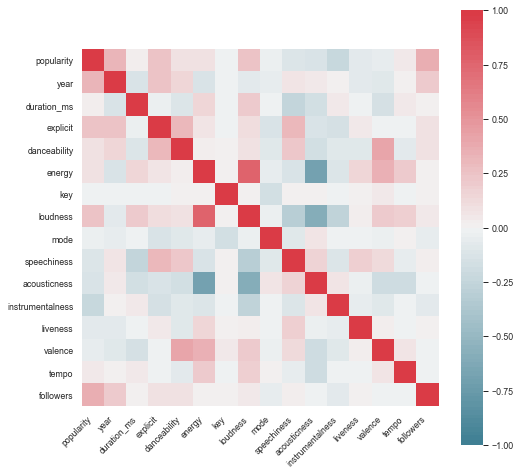

In [918]:
f = plt.figure(figsize=(8, 8))
corr = audio.corr()
ax = sns.heatmap(corr, vmin=-1, vmax=1, center=0,  cmap = sns.diverging_palette(220, 10, n=100),  square=True)
_ = ax.set_xticklabels(ax.get_xticklabels(), rotation=45, horizontalalignment='right')

<font size=4>After the Data Visualization, we build classification models and compare which model gives better accuracy.

<font size=4> We collect features not only for tracks, but also for albums and artist. And according to the the heatgram of correlation, the number of followers of artists weighs more than any single audio feature. Therefore, we built two datasets for classification model: one with the attribute of followers, and the other one without followers. 

<font size=4> **1. Dataset with Followers**

In [32]:
x1=audio.drop(columns=['year','explicit','duration_ms','popularity'])
y1=audio['popularity']
    # set bins for target variable 'popularity'
y1=pd.cut(y1,[0,60,100],precision=0,labels=False,right=False)
x1_train, x1_test, y1_train, y1_test = train_test_split(x1, y1,test_size=1/3,random_state=42, stratify=y1)

<font size=4>Oversampling

In [33]:
from imblearn.over_sampling import RandomOverSampler,SMOTE
print('before Oversampling:',Counter(y1_train))
oversample = RandomOverSampler(sampling_strategy='minority')
x2_train, y2_train = oversample.fit_resample(x1_train, y1_train)
print('After Oversampling:',Counter(y2_train))

before Oversampling: Counter({0: 13543, 1: 2115})
After Oversampling: Counter({0: 13543, 1: 13543})


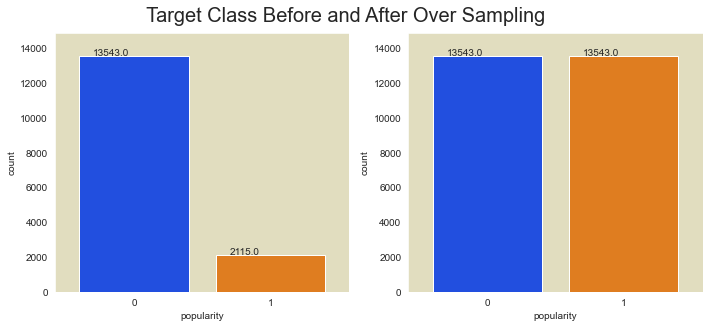

In [37]:
#print(Counter(target))
fig, (ax1, ax2) = plt.subplots(1, 2,figsize=(10,4.5))
fig.subplots_adjust(bottom=0.10, left=0.10, top = 0.900, right=1.00)
fig.suptitle(' Target Class Before and After Over Sampling', fontsize = 20)
sns.set_palette("bright")
sns.countplot(y1_train, ax=ax1)
ax1.margins(0.1)
ax1.set_facecolor("#e1ddbf")
for p in ax1.patches:
        ax1.annotate('{:.1f}'.format(p.get_height()), (p.get_x()+0.1, p.get_height()+50))
sns.set_palette("bright")
sns.countplot(y2_train, ax=ax2)
ax2.margins(0.1)
ax2.set_facecolor("#e1ddbf")
for p in ax2.patches:
        ax2.annotate('{:.1f}'.format(p.get_height()), (p.get_x()+0.1, p.get_height()+50))
sns.set_style('dark')

<font size=4>SMOTE

In [38]:
print('before SMOTE:',Counter(y1_train))
sm = SMOTE(sampling_strategy='minority')
x3_train,y3_train = sm.fit_resample(x1_train, y1_train)
print('After SMOTE:',Counter(y3_train))

before SMOTE: Counter({0: 13543, 1: 2115})
After SMOTE: Counter({0: 13543, 1: 13543})


<font size=4> **2. Dataset without Followers**

In [39]:
x2=audio.drop(columns=['year','explicit','popularity','followers'])
y2=audio['popularity']
    # set bins for target variable 'popularity'
y2=pd.cut(y2,[0,60,100],precision=0,labels=False,right=False)
x4_train, x4_test, y4_train, y4_test = train_test_split(x2, y2,test_size=1/3,random_state=42, stratify=y2)

<font size=4>Oversampling

In [40]:
from imblearn.over_sampling import RandomOverSampler,SMOTE
print('before Oversampling:',Counter(y4_train))
oversample = RandomOverSampler(sampling_strategy='minority')
x5_train, y5_train = oversample.fit_resample(x4_train, y4_train)
print('After Oversampling:',Counter(y5_train))

before Oversampling: Counter({0: 13543, 1: 2115})
After Oversampling: Counter({0: 13543, 1: 13543})


<font size=4>SMOTE

In [41]:
print('before SMOTE:',Counter(y4_train))
sm = SMOTE(sampling_strategy='minority')
x6_train,y6_train = sm.fit_resample(x4_train, y4_train)
print('After SMOTE:',Counter(y6_train))

before SMOTE: Counter({0: 13543, 1: 2115})
After SMOTE: Counter({0: 13543, 1: 13543})


### <font  color=darkslategray size=4> KNN

<font size=3> **1. Dataset with Followers**

In [42]:
s_x1=scaled_audio.drop(columns=['year','explicit','duration_ms','popularity'])
s_y1=audio['popularity']
    # set bins for target variable 'popularity'
s_y1=pd.cut(s_y1,[0,60,100],precision=0,labels=False,right=False)
s_x1_train, s_x1_test, s_y1_train, s_y1_test = train_test_split(s_x1, s_y1,
                                                                test_size=1/3,random_state=42, stratify=y2)

In [43]:
from imblearn.over_sampling import RandomOverSampler,SMOTE
print('before Oversampling:',Counter(s_y1_train))
oversample = RandomOverSampler(sampling_strategy='minority')
s_x2_train, s_y2_train = oversample.fit_resample(s_x1_train, s_y1_train)
print('After Oversampling:',Counter(s_y2_train))

before Oversampling: Counter({0: 13543, 1: 2115})
After Oversampling: Counter({0: 13543, 1: 13543})


In [44]:
print('before SMOTE:',Counter(y4_train))
sm = SMOTE(sampling_strategy='minority')
s_x3_train, s_y3_train = sm.fit_resample(s_x1_train, s_y1_train)
print('After SMOTE:',Counter(s_y3_train))

before SMOTE: Counter({0: 13543, 1: 2115})
After SMOTE: Counter({0: 13543, 1: 13543})


<font size=3> **2. Dataset without Followers**

In [45]:
s_x2=audio.drop(columns=['year','explicit','popularity','followers'])
s_y2=audio['popularity']
    # set bins for target variable 'popularity'
s_y2=pd.cut(s_y2,[0,60,100],precision=0,labels=False,right=False)
s_x4_train, s_x4_test, s_y4_train, s_y4_test = train_test_split(s_x2, s_y2,
                                                                test_size=1/3,random_state=42, stratify=s_y2)

In [46]:
from imblearn.over_sampling import RandomOverSampler,SMOTE
print('before Oversampling:',Counter(s_y4_train))
oversample = RandomOverSampler(sampling_strategy='minority')
s_x5_train, s_y5_train = oversample.fit_resample(s_x4_train, s_y4_train)
print('After Oversampling:',Counter(s_y5_train))

before Oversampling: Counter({0: 13543, 1: 2115})
After Oversampling: Counter({0: 13543, 1: 13543})


In [47]:
print('before SMOTE:',Counter(s_y4_train))
sm = SMOTE(sampling_strategy='minority')
s_x6_train,s_y6_train = sm.fit_resample(s_x4_train, s_y4_train)
print('After SMOTE:',Counter(s_y6_train))

before SMOTE: Counter({0: 13543, 1: 2115})
After SMOTE: Counter({0: 13543, 1: 13543})


In [48]:
def KNN(x_train,y_train,x_test,y_test):
    predict=KNeighborsClassifier().fit(x_train,y_train).predict(x_test)
    conf=sklearn.metrics.confusion_matrix(y_test,predict)
    report=classification_report(y_test,predict)
    return report

In [49]:
# un-preprocessed data with followers
print(KNN(s_x1_train,s_y1_train,s_x1_test,s_y1_test))
# Oversampling 
print(KNN(s_x2_train,s_y2_train,s_x1_test,s_y1_test))
# SMOTE
print(KNN(s_x3_train,s_y3_train,s_x1_test,s_y1_test))

              precision    recall  f1-score   support

           0       0.88      0.96      0.92      6772
           1       0.38      0.14      0.20      1057

    accuracy                           0.85      7829
   macro avg       0.63      0.55      0.56      7829
weighted avg       0.81      0.85      0.82      7829

              precision    recall  f1-score   support

           0       0.90      0.73      0.81      6772
           1       0.22      0.51      0.31      1057

    accuracy                           0.70      7829
   macro avg       0.56      0.62      0.56      7829
weighted avg       0.81      0.70      0.74      7829

              precision    recall  f1-score   support

           0       0.91      0.69      0.79      6772
           1       0.22      0.55      0.31      1057

    accuracy                           0.67      7829
   macro avg       0.56      0.62      0.55      7829
weighted avg       0.82      0.67      0.72      7829



In [50]:
# raw data without followers
print(Tree(s_x4_train,s_y4_train,s_x4_test,s_y4_test))
# Oversampling 
print(Tree(s_x5_train,s_y5_train,s_x4_test,s_y4_test))
# SMOTE
print(Tree(s_x6_train,s_y6_train,s_x4_test,s_y4_test))

NameError: name 'Tree' is not defined

### <font  color=darkslategray size=4> Naive Bayes

In [15]:
def NaiveBayes(x_train,y_train,x_test,y_test):
    predict=GaussianNB().fit(x_train,y_train).predict(x_test)
    conf=sklearn.metrics.confusion_matrix(y_test,predict)
    report=classification_report(y_test,predict)
    return report

In [51]:
# raw data with followers
print(NaiveBayes(x1_train,y1_train,x1_test,y1_test))
# Oversampling 
print(NaiveBayes(x2_train,y2_train,x1_test,y1_test))
# SMOTE
print(NaiveBayes(x3_train,y3_train,x1_test,y1_test))

              precision    recall  f1-score   support

           0       0.88      0.95      0.91      6772
           1       0.35      0.18      0.24      1057

    accuracy                           0.84      7829
   macro avg       0.61      0.56      0.57      7829
weighted avg       0.81      0.84      0.82      7829

              precision    recall  f1-score   support

           0       0.89      0.90      0.90      6772
           1       0.32      0.31      0.32      1057

    accuracy                           0.82      7829
   macro avg       0.61      0.61      0.61      7829
weighted avg       0.82      0.82      0.82      7829

              precision    recall  f1-score   support

           0       0.89      0.90      0.90      6772
           1       0.32      0.31      0.32      1057

    accuracy                           0.82      7829
   macro avg       0.61      0.61      0.61      7829
weighted avg       0.82      0.82      0.82      7829



In [52]:
# raw data without followers
print(NaiveBayes(x4_train,y4_train,x4_test,y4_test))
# Oversampling 
print(NaiveBayes(x5_train,y5_train,x4_test,y4_test))
# SMOTE
print(NaiveBayes(x6_train,y6_train,x4_test,y4_test))

              precision    recall  f1-score   support

           0       0.86      1.00      0.93      6772
           1       0.00      0.00      0.00      1057

    accuracy                           0.86      7829
   macro avg       0.43      0.50      0.46      7829
weighted avg       0.75      0.86      0.80      7829

              precision    recall  f1-score   support

           0       0.92      0.24      0.38      6772
           1       0.15      0.87      0.26      1057

    accuracy                           0.32      7829
   macro avg       0.54      0.55      0.32      7829
weighted avg       0.82      0.32      0.36      7829

              precision    recall  f1-score   support

           0       0.91      0.27      0.41      6772
           1       0.15      0.84      0.26      1057

    accuracy                           0.34      7829
   macro avg       0.53      0.55      0.33      7829
weighted avg       0.81      0.34      0.39      7829



### <font  color=darkslategray size=4> Desicion Tree

In [53]:
def Tree(x_train,y_train,x_test,y_test):
    predict=DecisionTreeClassifier(criterion='entropy',max_leaf_nodes=100).fit(x_train,y_train).predict(x_test)
    conf=sklearn.metrics.confusion_matrix(y_test,predict)
    report=classification_report(y_test,predict)
    return report

In [54]:
# raw data with followers
print(Tree(x1_train,y1_train,x1_test,y1_test))
# Oversampling 
print(Tree(x2_train,y2_train,x1_test,y1_test))
# SMOTE
print(Tree(x3_train,y3_train,x1_test,y1_test))

              precision    recall  f1-score   support

           0       0.88      0.98      0.93      6772
           1       0.58      0.17      0.26      1057

    accuracy                           0.87      7829
   macro avg       0.73      0.58      0.60      7829
weighted avg       0.84      0.87      0.84      7829

              precision    recall  f1-score   support

           0       0.94      0.72      0.81      6772
           1       0.28      0.69      0.40      1057

    accuracy                           0.72      7829
   macro avg       0.61      0.70      0.60      7829
weighted avg       0.85      0.72      0.76      7829

              precision    recall  f1-score   support

           0       0.92      0.72      0.81      6772
           1       0.26      0.62      0.36      1057

    accuracy                           0.70      7829
   macro avg       0.59      0.67      0.58      7829
weighted avg       0.83      0.70      0.75      7829



In [55]:
# raw data without followers
print(Tree(x4_train,y4_train,x4_test,y4_test))
# Oversampling 
print(Tree(x5_train,y5_train,x4_test,y4_test))
# SMOTE
print(Tree(x6_train,y6_train,x4_test,y4_test))

              precision    recall  f1-score   support

           0       0.86      0.99      0.92      6772
           1       0.12      0.01      0.01      1057

    accuracy                           0.86      7829
   macro avg       0.49      0.50      0.47      7829
weighted avg       0.76      0.86      0.80      7829

              precision    recall  f1-score   support

           0       0.91      0.56      0.69      6772
           1       0.19      0.64      0.29      1057

    accuracy                           0.57      7829
   macro avg       0.55      0.60      0.49      7829
weighted avg       0.81      0.57      0.64      7829

              precision    recall  f1-score   support

           0       0.89      0.75      0.81      6772
           1       0.19      0.38      0.25      1057

    accuracy                           0.70      7829
   macro avg       0.54      0.56      0.53      7829
weighted avg       0.79      0.70      0.74      7829



### <font  color=darkslategray size=4> Random Forest

In [56]:
def Forest(x_train,y_train,x_test,y_test):
    predict=RandomForestClassifier(max_leaf_nodes=100).fit(x_train,y_train).predict(x_test)
    conf=sklearn.metrics.confusion_matrix(y_test,predict)
    report=classification_report(y_test,predict)
    return report

In [57]:
# raw data with followers
print(Forest(x1_train,y1_train,x1_test,y1_test))
# Oversampling 
print(Forest(x2_train,y2_train,x1_test,y1_test))
# SMOTE
print(Forest(x3_train,y3_train,x1_test,y1_test))

              precision    recall  f1-score   support

           0       0.88      0.99      0.93      6772
           1       0.63      0.10      0.17      1057

    accuracy                           0.87      7829
   macro avg       0.75      0.54      0.55      7829
weighted avg       0.84      0.87      0.83      7829

              precision    recall  f1-score   support

           0       0.94      0.74      0.83      6772
           1       0.29      0.69      0.41      1057

    accuracy                           0.73      7829
   macro avg       0.62      0.71      0.62      7829
weighted avg       0.85      0.73      0.77      7829

              precision    recall  f1-score   support

           0       0.92      0.77      0.84      6772
           1       0.29      0.59      0.39      1057

    accuracy                           0.75      7829
   macro avg       0.61      0.68      0.61      7829
weighted avg       0.84      0.75      0.78      7829



In [58]:
# raw data without followers
print(Forest(x4_train,y4_train,x4_test,y4_test))
# Oversampling 
print(Forest(x5_train,y5_train,x4_test,y4_test))
# SMOTE
print(Forest(x6_train,y6_train,x4_test,y4_test))

              precision    recall  f1-score   support

           0       0.87      1.00      0.93      6772
           1       1.00      0.00      0.01      1057

    accuracy                           0.87      7829
   macro avg       0.93      0.50      0.47      7829
weighted avg       0.88      0.87      0.80      7829

              precision    recall  f1-score   support

           0       0.91      0.68      0.78      6772
           1       0.22      0.58      0.32      1057

    accuracy                           0.67      7829
   macro avg       0.57      0.63      0.55      7829
weighted avg       0.82      0.67      0.72      7829

              precision    recall  f1-score   support

           0       0.89      0.77      0.83      6772
           1       0.22      0.40      0.28      1057

    accuracy                           0.72      7829
   macro avg       0.55      0.59      0.55      7829
weighted avg       0.80      0.72      0.75      7829



### <font  color=darkslategray size=4> Selecting Best Features

In [59]:
from sklearn.feature_selection import SelectKBest,mutual_info_classif
bestfeatures = SelectKBest(score_func=mutual_info_classif, k=11)
fit = bestfeatures.fit(x1,y1,)
dfscores = pd.DataFrame(fit.scores_)
dfcolumns = pd.DataFrame(x1.columns) 
featureScores = pd.concat([dfcolumns,dfscores],axis=1)
featureScores.columns = ['Feature','Score'] 
print(featureScores.nlargest(10,'Score'))

             Feature     Score
11         followers  0.116437
3           loudness  0.014155
5        speechiness  0.009407
7   instrumentalness  0.008380
10             tempo  0.008199
1             energy  0.006840
0       danceability  0.005662
8           liveness  0.005543
6       acousticness  0.003751
9            valence  0.003531


In [60]:
from sklearn.feature_selection import SelectKBest,mutual_info_classif
bestfeatures = SelectKBest(score_func=mutual_info_classif, k=11)
fit = bestfeatures.fit(x2,y2,)
dfscores = pd.DataFrame(fit.scores_)
dfcolumns = pd.DataFrame(x2.columns) 
featureScores = pd.concat([dfcolumns,dfscores],axis=1)
featureScores.columns = ['Feature','Score'] 
print(featureScores.nlargest(10,'Score'))  

             Feature     Score
0        duration_ms  0.016725
4           loudness  0.012858
6        speechiness  0.011276
9           liveness  0.008640
8   instrumentalness  0.007333
11             tempo  0.007072
1       danceability  0.006681
2             energy  0.006558
7       acousticness  0.005390
5               mode  0.002937
